In [1]:
import dlib
import cv2
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# Drawing functions

In [2]:
def plot_img(image, title):
    fig = plt.figure(figsize=(6, 6,))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title(title)
    ax1.imshow(image)

def draw_facial_landmarks(landmarks, image, title):
    for landmark in landmarks:
        cv2.circle(image, (landmark[0], landmark[1]), 1, (0,255,0), -1)
    return plot_img(image, title)

def draw_convex_hull(cvxpoints, image, title):
    filler = np.array(cvxpoints)
    cv2.drawContours(image, [filler], -1, (0,0,255), 2)
    return plot_img(image, title)

def draw_delaunay_triangulation(delaunay_coord, image, title):
    for point in delaunay_coord:
        pt1 = totuple(point[0])
        pt2 = totuple(point[1])
        pt3 = totuple(point[2])
        cv2.line(image, pt1, pt2, (255,0,0), 1, cv2.LINE_AA, 0)
        cv2.line(image, pt2, pt3, (255,0,0), 1, cv2.LINE_AA, 0)
        cv2.line(image, pt3, pt1, (255,0,0), 1, cv2.LINE_AA, 0)
    return plot_img(image, title)
    
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

# Facial Landmark detection

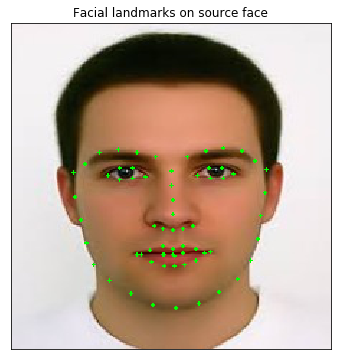

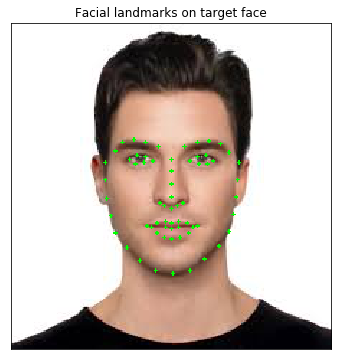

In [3]:
def get_facial_landmarks(predictor_path, image_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    image = io.imread(image_path)
    dets = detector(image, 1)
    for k, d in enumerate(dets):
        shape = predictor(image, d)
    landmarks = []
    for p in range(68):
        landmarks.append((shape.part(p).x, shape.part(p).y))
    return landmarks

source_img = './img/source-face.jpeg'
target_img = './img/target-face.jpeg'
predictor_path = './../detector_architectures/shape_predictor_68_face_landmarks.dat'

src_img = cv2.imread(source_img)
src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
dst_img = cv2.imread(target_img)
dst_img = cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB)

src_landmarks = get_facial_landmarks(predictor_path, source_img)
std_landmarks = get_facial_landmarks(predictor_path, target_img)

draw_facial_landmarks(src_landmarks, np.copy(src_img), 'Facial landmarks on source face')
draw_facial_landmarks(std_landmarks, np.copy(dst_img), 'Facial landmarks on target face')

# Convex hull

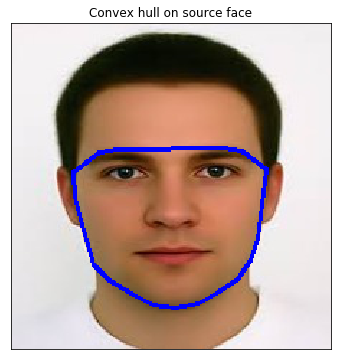

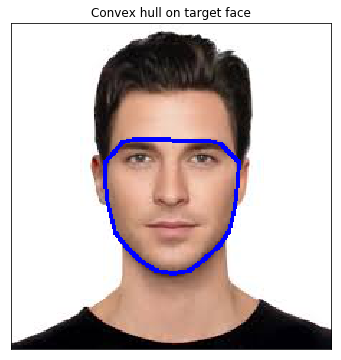

In [9]:
def get_convex_hull(landmarks):
    return cv2.convexHull(landmarks, returnPoints=False)

src_cvxhull_points = []
dst_cvxhull_points = []

hull = get_convex_hull(np.array(std_landmarks))
for i in range(0, len(hull)):
    src_cvxhull_points.append(src_landmarks[int(hull[i])])
    dst_cvxhull_points.append(std_landmarks[int(hull[i])])
    
draw_convex_hull(src_cvxhull_points, np.copy(src_img), 'Convex hull on source face')
draw_convex_hull(dst_cvxhull_points, np.copy(dst_img), 'Convex hull on target face')

# Delaunay triangulation

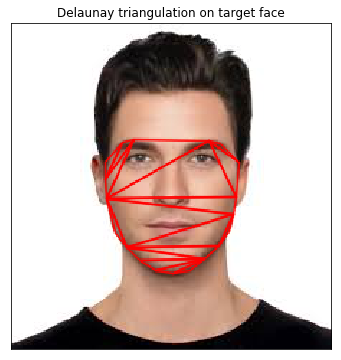

In [10]:
def rect_contains(rect, points):
    if points[0] < rect[0]: return False
    elif points[1] < rect[1]: return False
    elif points[0] > rect[0] + rect[2]: return False
    elif points[1] > rect[1] + rect[3]: return False
    return True

def get_delaunay_triangulation(dst_img, cvxpoints):
    rect = (0, 0, dst_img.shape[1], dst_img.shape[0])
    subdiv = cv2.Subdiv2D(rect)
    for point in cvxpoints:
        subdiv.insert(point)
    triangleList = subdiv.getTriangleList()
    delaunay = []
    pts = []
    for t in triangleList:
        pt = []
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0],t[1])
        pt2 = (t[2],t[3])
        pt3 = (t[4],t[5])
        if rect_contains(rect, pt1) and rect_contains(rect, pt2) and rect_contains(rect, pt3):
            ind = []
            for j in range(0, 3):
                for k in range(0, len(cvxpoints)):
                    if(abs(pt[j][0] - cvxpoints[k][0]) < 1. and abs(pt[j][1] - cvxpoints[k][1]) < 1.):
                        ind.append(k)
            if len(ind) == 3:
                pts.append((cvxpoints[ind[0]], cvxpoints[ind[1]], cvxpoints[ind[2]]))
                delaunay.append((ind[0], ind[1], ind[2]))
    return delaunay, pts

delaunay_points, coord_points = get_delaunay_triangulation(np.copy(dst_img), dst_cvxhull_points)
    
draw_delaunay_triangulation(coord_points, np.copy(dst_img), 'Delaunay triangulation on target face')

# Affine warp triangles

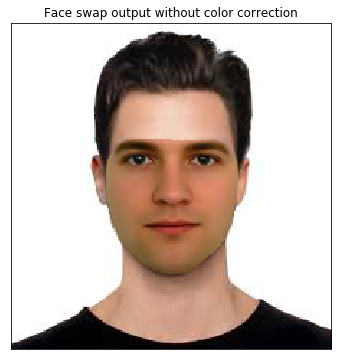

In [11]:
def affine_warp(src_img, dst_img, src_triangle, dst_triangle):
    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32(src_triangle))
    r2 = cv2.boundingRect(np.float32(dst_triangle))
    # Crop images and change coordinates 
    src_tri_cropped = []
    dst_tri_cropped = []

    for i in range(0,3):
        src_tri_cropped.append(( (src_triangle[i][0] - r1[0]), (src_triangle[i][1] - r1[1]) ))
        dst_tri_cropped.append(( (dst_triangle[i][0] - r2[0]), (dst_triangle[i][1] - r2[1]) ))
    
    src_img_cropped = src_img[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]
    # Estimate the affine transform
    warp_mat = cv2.getAffineTransform(np.float32(src_tri_cropped), np.float32(dst_tri_cropped))
    # Warp pixels inside bounding box
    dst_img_cropped = cv2.warpAffine(src_img_cropped, warp_mat, (r2[2], r2[3]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    # Mask pixels outside the triangle 
    mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
    
    cv2.fillConvexPoly(mask, np.int32(dst_tri_cropped), (1.,1.,1.), 16, 0)
    dst_img_cropped = dst_img_cropped * mask
    dst_img[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = dst_img[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
    dst_img[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = dst_img[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + dst_img_cropped
    return dst_img

s_image = np.copy(src_img)
d_image = np.copy(dst_img)

for i in range(0, len(delaunay_points)):
    src_triangle = []
    dst_triangle = []
    for j in range(0, 3):
        src_triangle.append(src_cvxhull_points[delaunay_points[i][j]])
        dst_triangle.append(dst_cvxhull_points[delaunay_points[i][j]])
    d_image = affine_warp(s_image, d_image, src_triangle, dst_triangle)
    
plot_img(d_image, 'Face swap output without color correction')

# Seamless cloning 

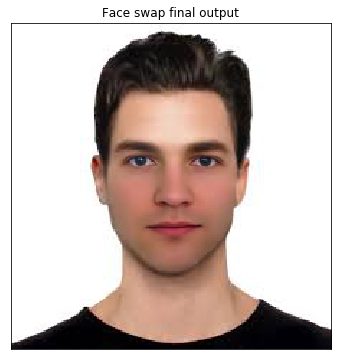

In [20]:
def seamless_cloning(swp_image, dst_image, dst_cvxhull_points):
    cvxhull = []
    for i in range(len(dst_cvxhull_points)):
        cvxhull.append((dst_cvxhull_points[i][0], dst_cvxhull_points[i][1]))
    mask = np.zeros(dst_img.shape, dtype=dst_img.dtype)
    cv2.fillConvexPoly(mask, np.int32(cvxhull), (255,255,255))
    r = cv2.boundingRect(np.float32([dst_cvxhull_points]))
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
    output = cv2.seamlessClone(np.uint8(np.copy(swp_image)), dst_img, mask, center, cv2.NORMAL_CLONE)
    return output 

swapped_face = seamless_cloning(d_image, dst_img, dst_cvxhull_points)
plot_img(swapped_face, 'Face swap final output')
